### Example to mimic old PTW

This is a notebook with parameter values set to mimic the old PTW calibration

In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
Precompiling project...


In [2]:
using PerlaTonettiWaugh, Plots, BenchmarkTools

┌ Info: Precompiling PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1192


loaded


Below is the calibration, the gbm and death rate set to be small values. The otheres are viturally taken from Tabe 1. The only ones that are a bit fuzzy are $\kappa$ which was rounded up and then the $\chi$ which is a bit higher. I beleve that this may have been a typo in the paper.

In [3]:
# Define common objects. 
parameters = parameters_old_paper
settings = settings_old_paper_defaults()
z_grid = settings.z
P = length(z_grid)

d_0 = 10.0 # This will get us near autarky.
d_T = parameters.d

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57] # Play with this if it is kicking back errors

# solve for stationary solution at t = 0
stationary_sol_atuk = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_atuk.Ω;
Ω_T = stationary_sol.Ω;

In [4]:
changed_parameters = false # set this to true if you drastically change the parameters

false

In [5]:
# display_stationary_sol(stationary_sol)
# uncomment to see all parameters for a steady state

#### Comparison of Steady States

First notice that the growth rate is near similar in autarky to that in Table 2. Then the second part computes the consumption equivalent 

In [6]:
print(stationary_sol_atuk.g,"\n")

print(100*(stationary_sol.U_bar/stationary_sol_atuk.U_bar-1),"\n")

lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_atuk.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

0.002225354634774104
21.102060942249203
SS to SS welfare gain: 25.955021732320184


So all this stuff is roughly matching up with what we had in Table 2. About a 1.38 growth rate, 13 percent increase in utility, 26 (24 in paper) in consumption units.

#### Transition Path

In [7]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 0));

In [8]:
if changed_parameters # will use the global solver to set a new initial condition, hopefully in the vicinity of the solution implied by the new parameters
    settings = merge(settings, (transition_iterations = 1000, ))
    @time result = solve_full_model_global(settings; impose_E_monotonicity_constraints = true)
    E_nodes = result.E_nodes;
    settings = merge(settings, (transition_x0 = E_nodes, ))
end

In [9]:
@time result = solve_full_model(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

120.568341 seconds (663.91 M allocations: 110.803 GiB, 11.91% gc time)


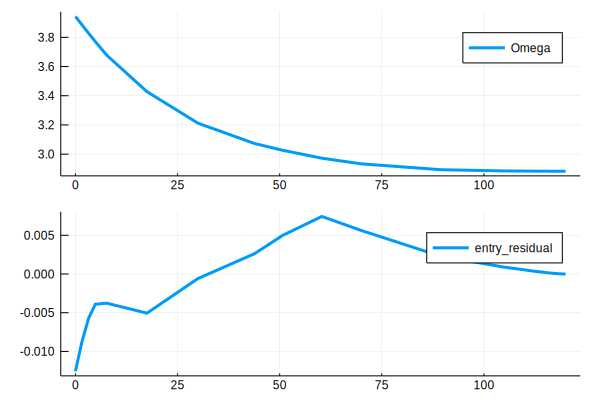

In [10]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

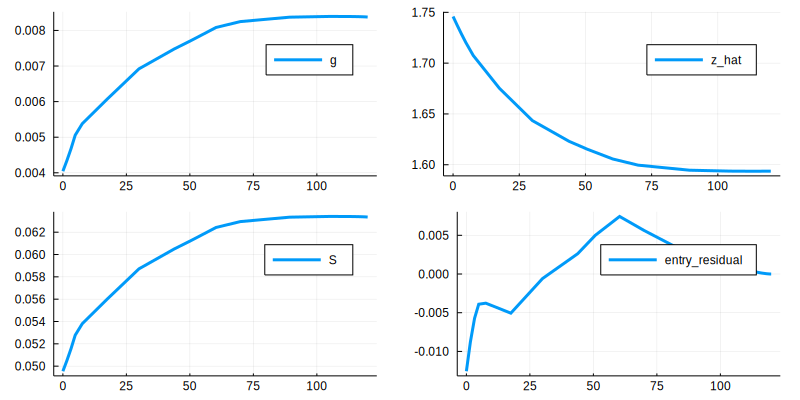

In [11]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

#### Welfare Including Transition Path

Here it is

In [12]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_atuk.U_bar, parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 29.714627620489466


So the transition makes welfare INCREASE by a factor of 4....

### Saving results in .csv files

In [13]:
using CSV
CSV.write("old_pwt_tpath-results.csv", solved)

"old_pwt_tpath-results.csv"